# Prepare some things
## Load some modules

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from keras.utils import to_categorical

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
import sklearn.metrics
from scipy.cluster import hierarchy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('../../')
from models import get_autoencoder_model, get_dec_model, get_vade_models, compute_p, compute_delta
from clustering_metrics import evaluate_clustering
from draw_embeddings import draw_multiple_labels

In [3]:
# Disable warnings output (TSNE outputs one very time)
import warnings
warnings.filterwarnings('ignore')

## Load the metabolomic data
(alrady min-max normalized)

In [4]:
metabol_exprs = pd.read_csv("../ExposomeChallengeData/datasets/metabol_joint_exprs_minmax.csv", index_col=0)
metabol_exprs.head()

serum_metab_1  serum_metab_2  serum_metab_3  serum_metab_4  \
430        0.224542       0.205024       0.490470       0.653163   
1187       0.402503       0.549489       0.828354       0.323912   
940        0.402503       0.556896       0.706195       0.534558   
936        0.462293       0.578889       0.451112       0.448921   
788        0.247137       0.571595       0.568414       0.417697   

      serum_metab_5  serum_metab_6  serum_metab_7  serum_metab_8  \
430        0.515652       0.483009       0.249523       0.340524   
1187       0.431621       0.491824       0.376192       0.348330   
940        0.544173       0.514375       0.397976       0.856991   
936        0.492050       0.553183       0.372429       0.544806   
788        0.432269       0.553183       0.531642       0.534388   

      serum_metab_9  serum_metab_10  ...  urine_metab_35  urine_metab_36  \
430        0.400406        0.574663  ...        0.485001        0.628204   
1187       0.213731        0.308797  ...        0.469040        0.816605   
940        0.358113        0.315096  ...        0.469738        0.627037   
936        0.388943        0.545676  ...        0.457602        0.738061   
788        0.536561        0.704749  ...        0.452021        0.639165   

      urine_metab_37  urine_metab_38  urine_metab_39  urine_metab_40  \
430         0.489431        0.640612        0.391376        0.665946   
1187        0.441328        0.000000        0.494475        0.696170   
940         0.519383        0.000000        0.326659        0.645060   
936         0.290234        0.177238        0.451808        0.487007   
788         0.329798        0.354477        0.250210        0.702331   

      urine_metab_41  urine_metab_42  urine_metab_43  urine_metab_44  
430         0.848047        0.360177        0.587031        0.605114  
1187        0.413698        0.396026        0.572658        0.619732  
940         0.841829        0.000000        0.653218        0.665950  
936         0.759121        0.000000        0.678092        0.729031  
788         0.778121        0.345500        0.554585        0.661642  

[5 rows x 221 columns]

In [5]:
metabol_exprs = metabol_exprs.to_numpy()

In [6]:
print("Shape of the data set:", metabol_exprs.shape)
print("Number of data points:", np.multiply(*metabol_exprs.shape))

Shape of the data set: (1152, 221)
Number of data points: 254592


## Load the categorical variables
(subset of phenotype and covariates data, already codified)

In [7]:
phenotype_cat = pd.read_csv("../ExposomeChallengeData/datasets/phenotype_cat.csv", index_col=0)
covariates_cat = pd.read_csv("../ExposomeChallengeData/datasets/covariates_cat.csv", index_col=0)
classes = pd.concat([phenotype_cat, covariates_cat], axis=1)
classes.head()

birth_weight  iq  behaviour  asthma  bmi  cohort  age  sex  education  \
1             3   0          3       0    1       3    1    0          1   
2             3   1          3       0    1       3    2    0          2   
3             3   0          3       1    3       3    1    0          2   
4             1   2          3       0    1       1    4    1          0   
5             3   0          1       0    1       2    4    0          0   

   native  parity  
1       2       0  
2       2       1  
3       2       1  
4       2       1  
5       2       0

In [8]:
print("Number of class variables:", classes.shape[1])

Number of class variables: 11


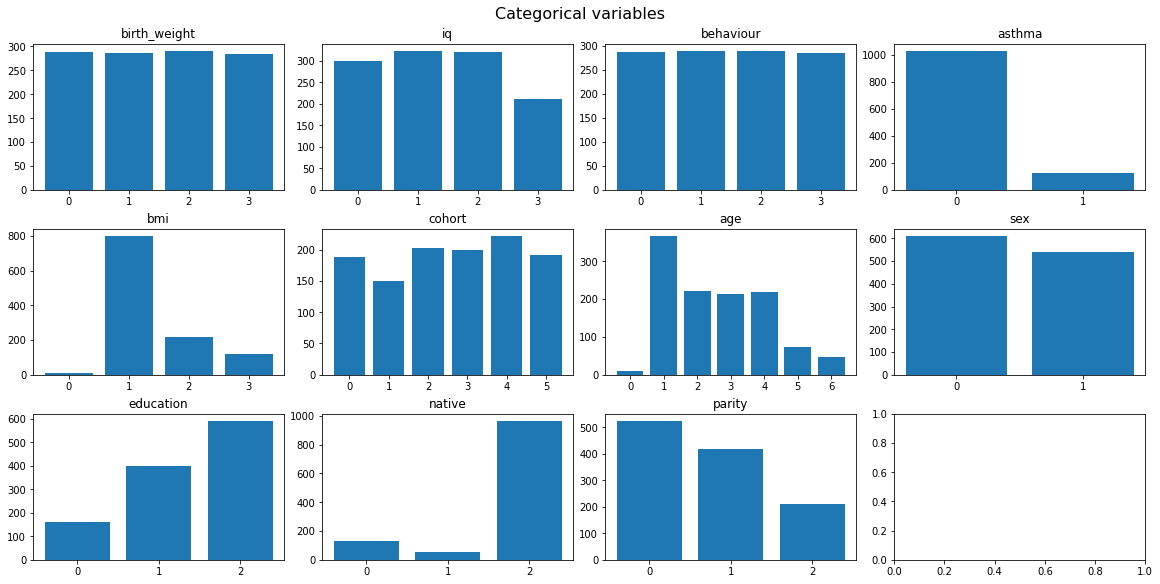

In [9]:
fig, axes = plt.subplots(3, 4, figsize=(16, 8), constrained_layout=True)
i = 0
for row in axes:
    for ax in row:
        counts = classes.iloc[:,i].value_counts()
        index = counts.index
        ax.bar(index, counts)
        ax.set_xticks(index)
        ax.title.set_text(classes.columns[i])
        i += 1
        if i == classes.shape[1]:
            break
fig.suptitle("Categorical variables", fontsize=16)
plt.show()

# Deep clustering models

In [10]:
categorical_variables = {2: ["asthma", "sex"],
                         3: ["education", "native", "parity"],
                         4: ["birth_weight", "iq", "behaviour", "bmi"],
                         6: ["cohort"],
                         7: ["age"]}

true_labels = {}
for k, variables in categorical_variables.items():
    true_labels[k] = {var: classes.loc[:,var] for var in variables}

cluster_labels = []
results = []

## DEC

In [11]:
INPUT_DIM = metabol_exprs.shape[1]  # 221
INTERMEDIATE_DIMS = (64, 32)

EPOCHS_PRETRAIN = 100
LEARNING_RATE_PRETRAIN = 1
MOMENTUM_PRETRAIN = 0.5

EPOCHS_FINETUNE = 100
LEARNING_RATE_FINETUNE = 1e-4
MOMENTUM_FINETUNE = 0.9

BATCH_SIZE = 32
SCHEDULE = 10
DELTA_THRESHOLD = 0.001

In [12]:
def dec_callback(epoch, logs):
    global p
    global c_last
    
    if (epoch+1) % SCHEDULE == 0:
        q = model_dec.soft_assignment(metabol_exprs)
        p = compute_p(q)
        
        c_new = q.numpy().argmax(1)
        delta = compute_delta(c_new, c_last)
        c_last = np.copy(c_new)
        # print(f"Delta: {delta:.3f}")
        if (delta < DELTA_THRESHOLD):
            model_dec.stop_training = True
            
callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=dec_callback)

K=2 - Pretraining AE [loss: 0.0148] - Fine-tunning DEC [loss: 1.5924]
asthma ['Acc: 0.893', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.695']
sex ['Acc: 0.530', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.695']
K=3 - Pretraining AE [loss: 0.0158] - Fine-tunning DEC [loss: 3.1429]
education ['Acc: 0.513', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.635']
native ['Acc: 0.838', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.635']
parity ['Acc: 0.455', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.635']
K=4 - Pretraining AE [loss: 0.0152] - Fine-tunning DEC [loss: 4.8197]
birth_weight ['Acc: 0.272', 'ARI: 0.001', 'AMI: 0.002', 'Sil: 0.449']
iq ['Acc: 0.294', 'ARI: 0.004', 'AMI: 0.002', 'Sil: 0.449']
behaviour ['Acc: 0.274', 'ARI: -0.000', 'AMI: -0.001', 'Sil: 0.449']
bmi ['Acc: 0.694', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.449']
K=6 - Pretraining AE [loss: 0.0137] - Fine-tunning DEC [loss: 6.6233]
cohort ['Acc: 0.214', 'ARI: 0.003', 'AMI: 0.002', 'Sil: 0.399']
K=7 - Pretraining AE [loss: 0.0140] - Fine-tunning DEC [loss: 6.9647]
age ['

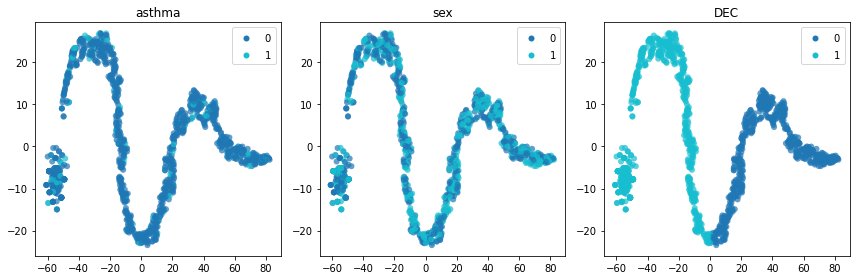

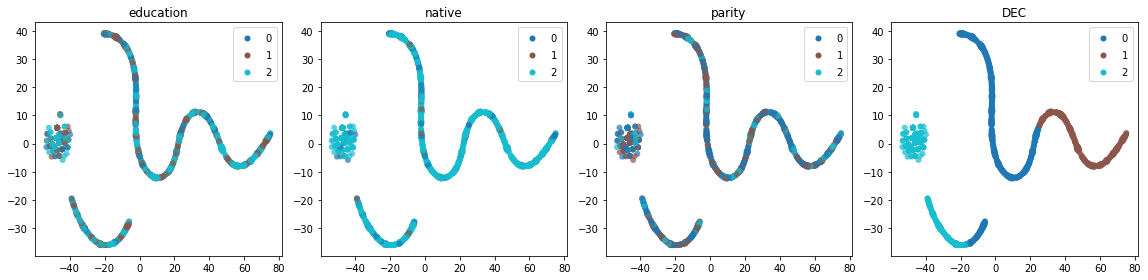

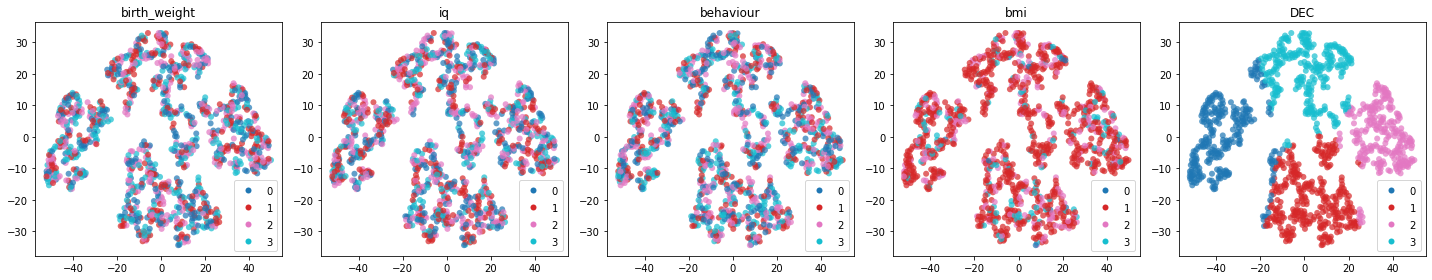

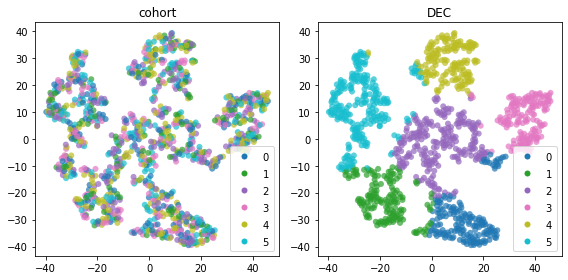

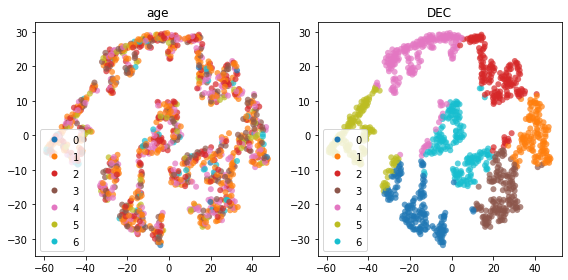

In [14]:
rl_method = "DEC"
clust_method = "K-Means"
data = metabol_exprs

for k, variables in categorical_variables.items():
    LATENT_DIM = k
    N_CLUSTERS = k
    
    # Construct and pretrain AE
    print(f"K={k} - Pretraining AE", end=" ")
    model_ae = get_autoencoder_model(INPUT_DIM, LATENT_DIM, INTERMEDIATE_DIMS)
    optimizer = keras.optimizers.SGD(learning_rate=LEARNING_RATE_PRETRAIN,
                                     momentum=MOMENTUM_PRETRAIN)
    loss = "mse"
    model_ae.compile(optimizer=optimizer, loss=loss)
    history = model_ae.fit(data, data,
                           epochs=EPOCHS_PRETRAIN,
                           batch_size=BATCH_SIZE,
                           verbose=0)
    print(f"[loss: {history.history['loss'][-1]:.4f}]", end=" ")
    
    # Construct DEC
    print("- Fine-tunning DEC", end=" ")
    model_dec = get_dec_model(model_ae.encoder, N_CLUSTERS)
    
    # Initialize parameters
    z_dec = model_dec.encode(data)
    kmeans = KMeans(n_clusters=N_CLUSTERS, n_init=30)
    kmeans.fit(z_dec)
    for weight in model_dec.trainable_weights:
        if weight.name == "centroids:0":
            weight.assign(K.constant(kmeans.cluster_centers_))

    p = compute_p(to_categorical(kmeans.labels_))
    c_last = kmeans.labels_

    # Fine-tune the model
    optimizer = keras.optimizers.SGD(learning_rate=LEARNING_RATE_FINETUNE, 
                                     momentum=MOMENTUM_FINETUNE)
    model_dec.compile(optimizer=optimizer)
    history = model_dec.fit(data, p,
                            epochs=EPOCHS_FINETUNE,
                            batch_size=BATCH_SIZE,
                            callbacks = callback,
                            verbose=0)
    print(f"[loss: {history.history['loss'][-1]:.4f}]")
    
    # Compute the cluster assignments
    c_dec = model_dec.classify(data)
    cluster_labels.append({"rl_method": rl_method, 
                           "clust_method": clust_method, 
                           "n_clusters": k, 
                           "labels": c_dec})
    
    # Compute metrics
    z_dec = model_dec.encode(data)
    for variable, labels in true_labels[k].items():
        metrics = evaluate_clustering(z_dec, labels, c_dec, False)
        print(variable, [f'{metric}: {value:.3f}' for metric, value in metrics.items()])
        result = {"rl_method": rl_method, 
                  "clust_method": clust_method, 
                  "n_clusters": k, 
                  "variable": variable}
        result.update(metrics)
        results.append(result)
    
    # Draw the embeddings
    tsne = TSNE(n_components=2, init='pca')
    z_dec_tsne = tsne.fit_transform(z_dec)

    labels = true_labels[k].copy()
    labels.update({rl_method: c_dec})
    draw_multiple_labels(z_dec_tsne, labels)

## VaDE

In [15]:
INPUT_DIM = metabol_exprs.shape[1]  # 221
INTERMEDIATE_DIMS = (64, 32)

EPOCHS_PRETRAIN = 20
LEARNING_RATE_PRETRAIN = 1
MOMENTUM_PRETRAIN = 0.9

EPOCHS_FINETUNE = 50
LEARNING_RATE_FINETUNE = 1e-5
MOMENTUM_FINETUNE = 0.9

BATCH_SIZE = 32
SCHEDULE = 10

In [16]:
def scheduler(epoch, lr):
    if (epoch+1) % SCHEDULE == 0:
        lr = lr * 0.9
    return lr

callback = [tf.keras.callbacks.LearningRateScheduler(scheduler),]

K=2 - Pretraining AE [loss: 0.6475] - Fine-tunning VaDE [loss: 145.2209]
asthma ['Acc: 0.893', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.290']
sex ['Acc: 0.530', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.290']
K=3 - Pretraining AE [loss: 0.6456] - Fine-tunning VaDE [loss: 145.3799]
education ['Acc: 0.513', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.163']
native ['Acc: 0.838', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.163']
parity ['Acc: 0.455', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.163']
K=4 - Pretraining AE [loss: 0.6444] - Fine-tunning VaDE [loss: 146.1796]
birth_weight ['Acc: 0.278', 'ARI: 0.001', 'AMI: 0.001', 'Sil: 0.146']
iq ['Acc: 0.299', 'ARI: 0.002', 'AMI: 0.002', 'Sil: 0.146']
behaviour ['Acc: 0.266', 'ARI: -0.001', 'AMI: -0.001', 'Sil: 0.146']
bmi ['Acc: 0.694', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.146']
K=6 - Pretraining AE [loss: 0.6415] - Fine-tunning VaDE [Got NaN as loss. Retrying.]
K=6 - Pretraining AE [loss: 0.6427] - Fine-tunning VaDE [Got NaN as loss. Retrying.]
K=6 - Pretraining AE [loss: 0.6

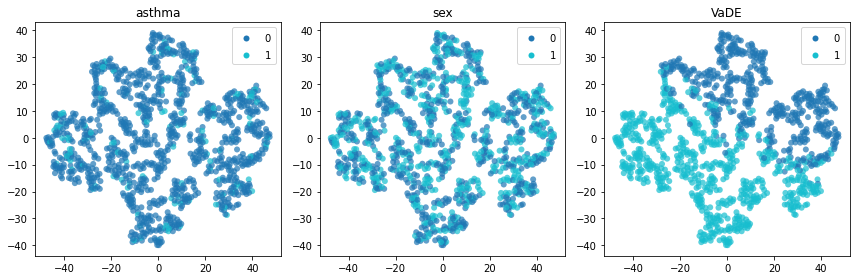

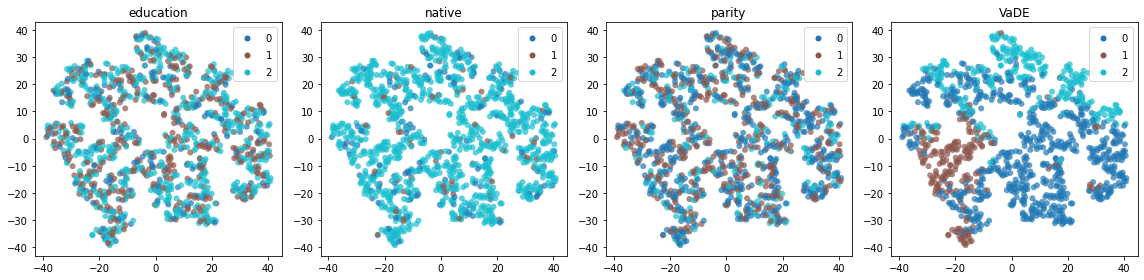

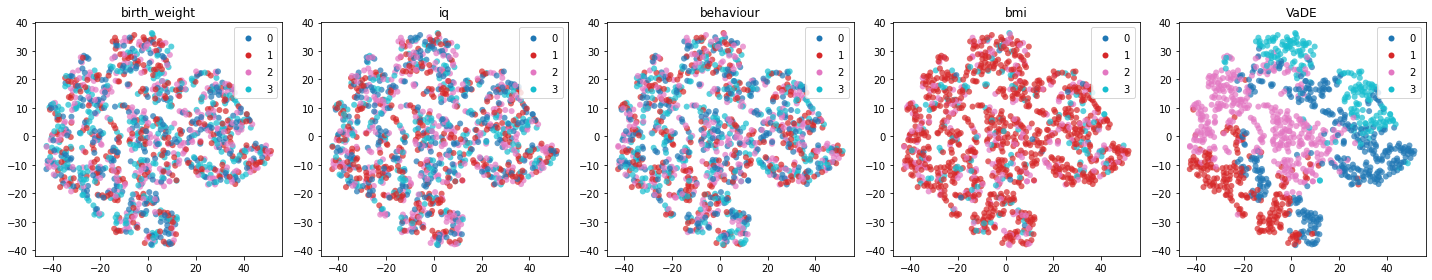

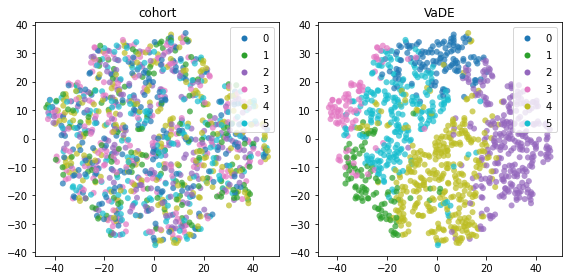

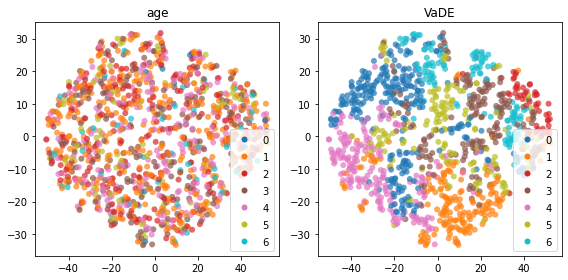

In [17]:
rl_method = "VaDE"
clust_method = "GMM"
data = metabol_exprs

for k, variables in categorical_variables.items():
    LATENT_DIM = k
    N_CLUSTERS = k
    
    # Construct and train the VaDE model.
    # If loss == NaN: retry.
    while True:
        # Construct models and pretrain AE
        print(f"K={k} - Pretraining AE", end=" ")
        model_pretrain, model_vade = get_vade_models(N_CLUSTERS, INPUT_DIM, LATENT_DIM, INTERMEDIATE_DIMS)
        optimizer = keras.optimizers.SGD(learning_rate=LEARNING_RATE_PRETRAIN,
                                         momentum=MOMENTUM_PRETRAIN)
        loss = keras.losses.BinaryCrossentropy()
        model_pretrain.compile(optimizer=optimizer, loss=loss)
        history = model_pretrain.fit(data,
                                     epochs=EPOCHS_PRETRAIN,
                                     batch_size=BATCH_SIZE,
                                     verbose=0)
        print(f"[loss: {history.history['loss'][-1]:.4f}]", end=" ")

        # Initialize parameters
        z_vade = model_vade.encode_only_mu(data)
        gmm = GaussianMixture(n_components=N_CLUSTERS, covariance_type='diag', n_init=30)
        gmm.fit(z_vade)
        for weight in model_vade.trainable_weights:
            if weight.name == "pi:0":
                weight.assign(K.log(K.constant(gmm.weights_)))
            elif weight.name == "mu:0":
                weight.assign(K.constant(gmm.means_))
            elif weight.name == "logvar:0":
                weight.assign(K.log(K.constant(gmm.covariances_)))

        # Fine-tune the model
        print("- Fine-tunning VaDE", end=" ")
        optimizer = keras.optimizers.SGD(learning_rate=LEARNING_RATE_FINETUNE,
                                         momentum=MOMENTUM_FINETUNE)
        model_vade.compile(optimizer=optimizer)
        history = model_vade.fit(data,
                                 epochs=EPOCHS_FINETUNE,
                                 batch_size=BATCH_SIZE,
                                 callbacks = callback,
                                 verbose=0)
        #If loss == NaN: retry.
        if np.isnan(history.history['loss'][-1]):
            print("[Got NaN as loss. Retrying.]")
            continue
        else:
            print(f"[loss: {history.history['loss'][-1]:.4f}]")
            break

    # Compute the cluster assignments
    c_vade = model_vade.classify(data).numpy()
    cluster_labels.append({"rl_method": rl_method, 
                           "clust_method": clust_method, 
                           "n_clusters": k, 
                           "labels": c_vade})
    
    # Compute metrics
    z_vade = model_vade.encode_only_mu(data)
    for variable, labels in true_labels[k].items():
        metrics = evaluate_clustering(z_vade, labels, c_vade, False)
        print(variable, [f'{metric}: {value:.3f}' for metric, value in metrics.items()])
        result = {"rl_method": rl_method, 
                  "clust_method": clust_method, 
                  "n_clusters": k, 
                  "variable": variable}
        result.update(metrics)
        results.append(result)
    
    # Draw the embeddings
    tsne = TSNE(n_components=2, init='pca')
    z_vade_tsne = tsne.fit_transform(z_vade)

    labels = true_labels[k].copy()
    labels.update({rl_method: c_vade})
    draw_multiple_labels(z_vade_tsne, labels)

# Data augmentation, then DC


## Prepare the augmented data set

The data augmentation method is the following: first, sample over a normal distribution with mean 0 and a small standard deviation (as to not change the structure of the data). Then, sum the original data to the sampled points.

I'll generate a new dataset 10 times as big as the original, then evaluate the models over the new data.

I'll choose a standard deviation an order of magnitude smaller than the mean of the standard deviations over all the variables.

In [18]:
# Mean standard deviation over all the variables:
metabol_exprs.std(axis=0).mean()

0.13517043370394516

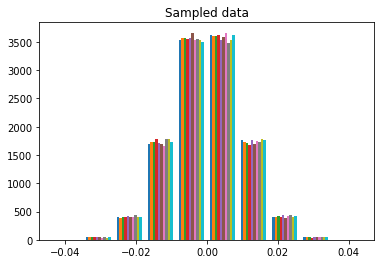

In [19]:
# Sample from a normal distribution (mean=0, std=0.01)
n_data_points = metabol_exprs.shape[0] * metabol_exprs.shape[1]
metabol_augmented = np.random.normal(0, 0.01, 10 * n_data_points).reshape((10* metabol_exprs.shape[0]), metabol_exprs.shape[1])
plt.hist(metabol_augmented[:,:10])
plt.title("Sampled data");

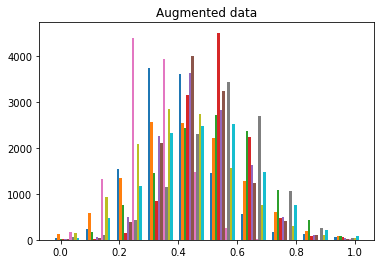

In [20]:
metabol_augmented += metabol_exprs.repeat(10, axis=0)
plt.hist(metabol_augmented[:,:10])
plt.title("Augmented data");

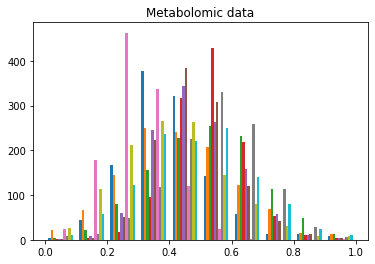

In [21]:
plt.hist(metabol_exprs[:,:10])
plt.title("Metabolomic data");

In [22]:
labels_augmented = {}
for k, variables in categorical_variables.items():
    labels_augmented[k] = {var: classes.loc[:,var].repeat(10) for var in variables}

## DEC

In [23]:
INPUT_DIM = metabol_augmented.shape[1]  # 221
INTERMEDIATE_DIMS = (64, 32)

EPOCHS_PRETRAIN = 100
LEARNING_RATE_PRETRAIN = 1e-1
MOMENTUM_PRETRAIN = 0.9

EPOCHS_FINETUNE = 100
LEARNING_RATE_FINETUNE = 1e-4
MOMENTUM_FINETUNE = 0.9

BATCH_SIZE = 32
SCHEDULE = 10
DELTA_THRESHOLD = 0.001

In [24]:
def dec_callback(epoch, logs):
    global p
    global c_last
    
    if (epoch+1) % SCHEDULE == 0:
        q = model_dec.soft_assignment(metabol_augmented)
        p = compute_p(q)
        
        c_new = q.numpy().argmax(1)
        delta = compute_delta(c_new, c_last)
        c_last = np.copy(c_new)
        # print(f"Delta: {delta:.3f}")
        if (delta < DELTA_THRESHOLD):
            model_dec.stop_training = True
            
callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=dec_callback)

K=2 - Pretraining AE [loss: 0.0156] - Fine-tunning DEC [loss: 0.3590]
asthma ['Acc: 0.893', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.950']
sex ['Acc: 0.530', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.950']
K=3 - Pretraining AE [loss: 0.0128] - Fine-tunning DEC [loss: 0.7715]
education ['Acc: 0.513', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.906']
native ['Acc: 0.838', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.906']
parity ['Acc: 0.455', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.906']
K=4 - Pretraining AE [loss: 0.0128] - Fine-tunning DEC [loss: 1.7519]
birth_weight ['Acc: 0.272', 'ARI: 0.001', 'AMI: 0.001', 'Sil: 0.767']
iq ['Acc: 0.306', 'ARI: 0.006', 'AMI: 0.003', 'Sil: 0.767']
behaviour ['Acc: 0.302', 'ARI: 0.003', 'AMI: 0.003', 'Sil: 0.767']
bmi ['Acc: 0.694', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.767']
K=6 - Pretraining AE [loss: 0.0128] - Fine-tunning DEC [loss: 2.5380]
cohort ['Acc: 0.201', 'ARI: -0.000', 'AMI: -0.000', 'Sil: 0.771']
K=7 - Pretraining AE [loss: 0.0120] - Fine-tunning DEC [loss: 3.1896]
age ['

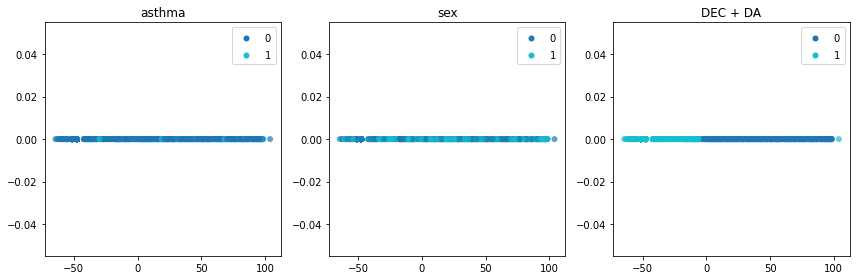

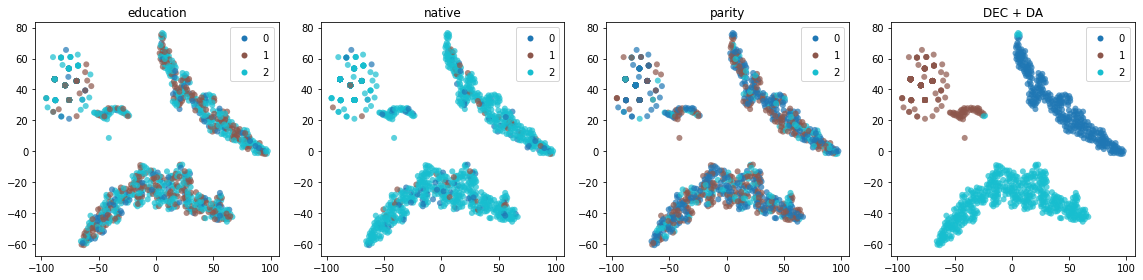

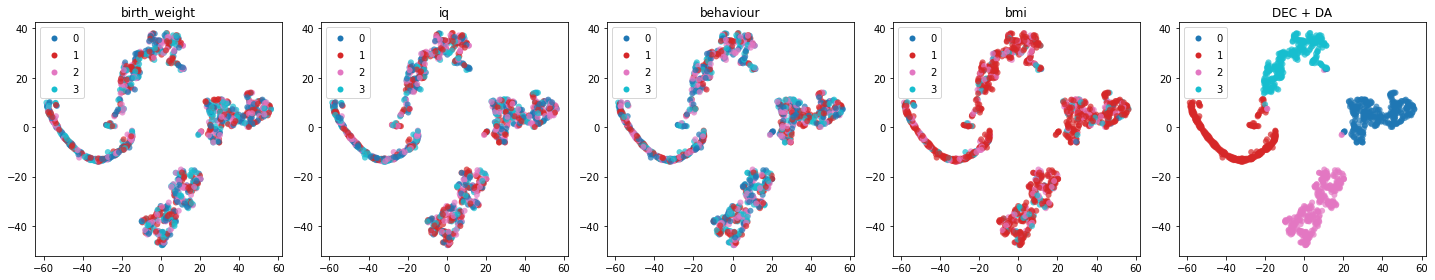

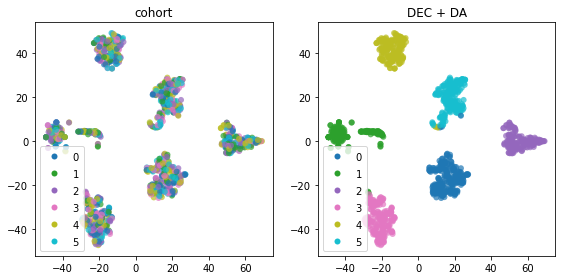

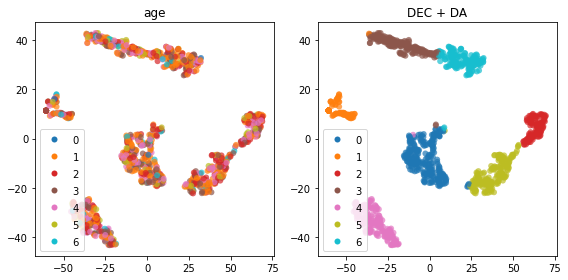

In [25]:
rl_method = "DEC + DA"
clust_method = "K-Means"
data = metabol_augmented

for k, variables in categorical_variables.items():
    LATENT_DIM = k
    N_CLUSTERS = k
    
    # Construct and pretrain AE
    print(f"K={k} - Pretraining AE", end=" ")
    model_ae = get_autoencoder_model(INPUT_DIM, LATENT_DIM, INTERMEDIATE_DIMS)
    optimizer = keras.optimizers.SGD(learning_rate=LEARNING_RATE_PRETRAIN,
                                     momentum=MOMENTUM_PRETRAIN)
    loss = "mse"
    model_ae.compile(optimizer=optimizer, loss=loss)
    history = model_ae.fit(data, data,
                           epochs=EPOCHS_PRETRAIN,
                           batch_size=BATCH_SIZE,
                           verbose=0)
    print(f"[loss: {history.history['loss'][-1]:.4f}]", end=" ")
    
    # Construct DEC
    print("- Fine-tunning DEC", end=" ")
    model_dec = get_dec_model(model_ae.encoder, N_CLUSTERS)
    
    # Initialize parameters
    z_dec = model_dec.encode(data)
    kmeans = KMeans(n_clusters=N_CLUSTERS, n_init=30)
    kmeans.fit(z_dec)
    for weight in model_dec.trainable_weights:
        if weight.name == "centroids:0":
            weight.assign(K.constant(kmeans.cluster_centers_))

    p = compute_p(to_categorical(kmeans.labels_))
    c_last = kmeans.labels_

    # Fine-tune the model
    optimizer = keras.optimizers.SGD(learning_rate=LEARNING_RATE_FINETUNE, 
                                     momentum=MOMENTUM_FINETUNE)
    model_dec.compile(optimizer=optimizer)
    history = model_dec.fit(data, p,
                            epochs=EPOCHS_FINETUNE,
                            batch_size=BATCH_SIZE,
                            callbacks = callback,
                            verbose=0)
    print(f"[loss: {history.history['loss'][-1]:.4f}]")
    
    # Compute the cluster assignments
    c_dec = model_dec.classify(metabol_exprs)
    cluster_labels.append({"rl_method": rl_method, 
                           "clust_method": clust_method, 
                           "n_clusters": k, 
                           "labels": c_dec})
    
    # Compute metrics
    z_dec = model_dec.encode(metabol_exprs)
    for variable, labels in true_labels[k].items():
        metrics = evaluate_clustering(z_dec, labels, c_dec, False)
        print(variable, [f'{metric}: {value:.3f}' for metric, value in metrics.items()])
        result = {"rl_method": rl_method, 
                  "clust_method": clust_method, 
                  "n_clusters": k, 
                  "variable": variable}
        result.update(metrics)
        results.append(result)
    
    # Draw the embeddings
    tsne = TSNE(n_components=2, init='pca')
    z_dec_tsne = tsne.fit_transform(z_dec)

    labels = true_labels[k].copy()
    labels.update({rl_method: c_dec})
    draw_multiple_labels(z_dec_tsne, labels)

## VaDE

In [26]:
INPUT_DIM = metabol_augmented.shape[1]  # 221
INTERMEDIATE_DIMS = (64, 32)

EPOCHS_PRETRAIN = 20
LEARNING_RATE_PRETRAIN = 0.1
MOMENTUM_PRETRAIN = 0.9

EPOCHS_FINETUNE = 20
LEARNING_RATE_FINETUNE = 1e-5
MOMENTUM_FINETUNE = 0.5

BATCH_SIZE = 32
SCHEDULE = 10

In [27]:
def scheduler(epoch, lr):
    if (epoch+1) % SCHEDULE == 0:
        lr = lr * 0.9
    return lr

callback = [tf.keras.callbacks.LearningRateScheduler(scheduler),]

K=2 - Pretraining AE [loss: 0.6469] - Fine-tunning VaDE [loss: 145.2290]
asthma ['Acc: 0.893', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.354']
sex ['Acc: 0.530', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.354']
K=3 - Pretraining AE [loss: 0.6459] - Fine-tunning VaDE [loss: 145.5345]
education ['Acc: 0.513', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.181']
native ['Acc: 0.838', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.181']
parity ['Acc: 0.466', 'ARI: 0.008', 'AMI: 0.005', 'Sil: 0.181']
K=4 - Pretraining AE [loss: 0.6442] - Fine-tunning VaDE [loss: 146.3393]
birth_weight ['Acc: 0.275', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.175']
iq ['Acc: 0.309', 'ARI: 0.001', 'AMI: 0.002', 'Sil: 0.175']
behaviour ['Acc: 0.271', 'ARI: -0.001', 'AMI: -0.001', 'Sil: 0.175']
bmi ['Acc: 0.694', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.175']
K=6 - Pretraining AE [loss: 0.6419] - Fine-tunning VaDE [Got NaN as loss. Retrying.]
K=6 - Pretraining AE [loss: 0.6404] - Fine-tunning VaDE [loss: 146.7519]
cohort ['Acc: 0.218', 'ARI: 0.002', 'AMI: 0

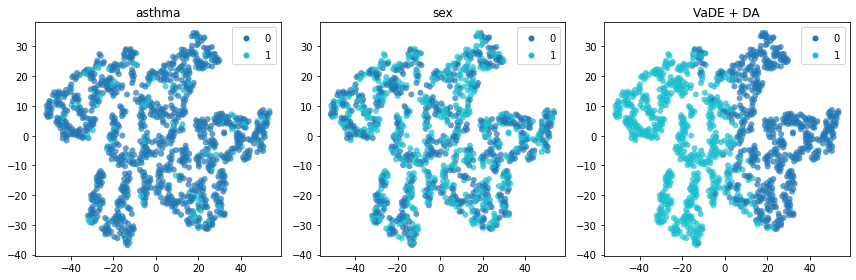

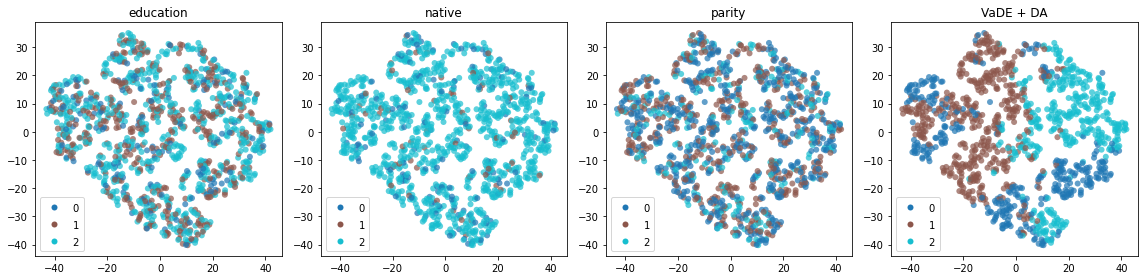

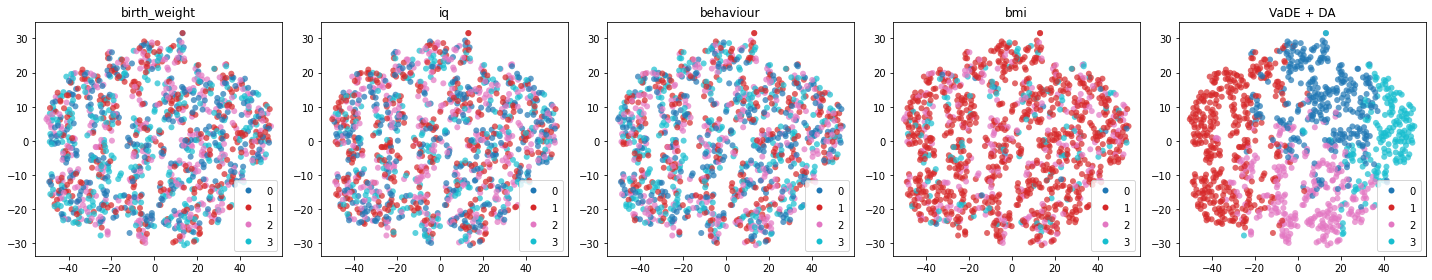

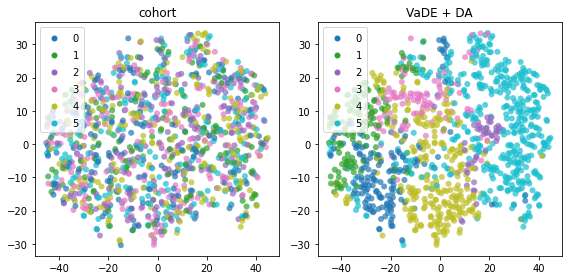

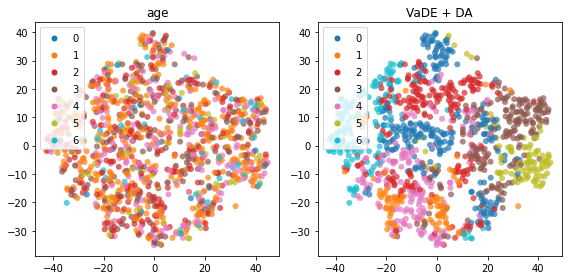

In [28]:
rl_method = "VaDE + DA"
clust_method = "GMM"
data = metabol_augmented

for k, variables in categorical_variables.items():
    LATENT_DIM = k
    N_CLUSTERS = k
    
    # Construct and train the VaDE model.
    # If loss == NaN: retry.
    while True:
        # Construct models and pretrain AE
        print(f"K={k} - Pretraining AE", end=" ")
        model_pretrain, model_vade = get_vade_models(N_CLUSTERS, INPUT_DIM, LATENT_DIM, INTERMEDIATE_DIMS)
        optimizer = keras.optimizers.SGD(learning_rate=LEARNING_RATE_PRETRAIN,
                                         momentum=MOMENTUM_PRETRAIN)
        loss = keras.losses.BinaryCrossentropy()
        model_pretrain.compile(optimizer=optimizer, loss=loss)
        history = model_pretrain.fit(data,
                                     epochs=EPOCHS_PRETRAIN,
                                     batch_size=BATCH_SIZE,
                                     verbose=0)
        print(f"[loss: {history.history['loss'][-1]:.4f}]", end=" ")

        # Initialize parameters
        z_vade = model_vade.encode_only_mu(data)
        gmm = GaussianMixture(n_components=N_CLUSTERS, covariance_type='diag', n_init=30)
        gmm.fit(z_vade)
        for weight in model_vade.trainable_weights:
            if weight.name == "pi:0":
                weight.assign(K.log(K.constant(gmm.weights_)))
            elif weight.name == "mu:0":
                weight.assign(K.constant(gmm.means_))
            elif weight.name == "logvar:0":
                weight.assign(K.log(K.constant(gmm.covariances_)))

        # Fine-tune the model
        print("- Fine-tunning VaDE", end=" ")
        optimizer = keras.optimizers.SGD(learning_rate=LEARNING_RATE_FINETUNE,
                                         momentum=MOMENTUM_FINETUNE)
        model_vade.compile(optimizer=optimizer)
        history = model_vade.fit(data,
                                 epochs=EPOCHS_FINETUNE,
                                 batch_size=BATCH_SIZE,
                                 callbacks = callback,
                                 verbose=0)
        #If loss == NaN: retry.
        if np.isnan(history.history['loss'][-1]):
            print("[Got NaN as loss. Retrying.]")
            continue
        else:
            print(f"[loss: {history.history['loss'][-1]:.4f}]")
            break

    # Compute the cluster assignments
    c_vade = model_vade.classify(metabol_exprs).numpy()
    cluster_labels.append({"rl_method": rl_method, 
                           "clust_method": clust_method, 
                           "n_clusters": k, 
                           "labels": c_vade})
    
    # Compute metrics
    z_vade = model_vade.encode_only_mu(metabol_exprs)
    for variable, labels in true_labels[k].items():
        metrics = evaluate_clustering(z_vade, labels, c_vade, False)
        print(variable, [f'{metric}: {value:.3f}' for metric, value in metrics.items()])
        result = {"rl_method": rl_method, 
                  "clust_method": clust_method, 
                  "n_clusters": k, 
                  "variable": variable}
        result.update(metrics)
        results.append(result)
    
    # Draw the embeddings
    tsne = TSNE(n_components=2, init='pca')
    z_vade_tsne = tsne.fit_transform(z_vade)

    labels = true_labels[k].copy()
    labels.update({rl_method: c_vade})
    draw_multiple_labels(z_vade_tsne, labels)

# Results

## Metrics

In [29]:
results = pd.DataFrame(results)
# Save the metrics on a CSV file
results.to_csv("results/metrics_deepclust_mpl.csv", index=False)

results_mean = results.set_index(["rl_method","clust_method"]).groupby(level=[0,1]).mean()
results_mean = results_mean.iloc[:,1:]
results_mean.style.background_gradient(axis=0, cmap="cividis", text_color_threshold=0.3, subset=['Acc','ARI','AMI','Sil']).format('{:.2f}', subset=['Acc','ARI','AMI','Sil'])

In [30]:
results.style.background_gradient(axis=0, cmap="cividis", text_color_threshold=0.3, subset=['Acc','ARI','AMI','Sil']).format('{:.2f}', subset=['Acc','ARI','AMI','Sil'])

There is no match between any of the clusters found and the categorical data. The high accuracy values on the variables "asthma" and "native" are due to there being a groups which contains the majority of the observations, so a random assignment would also get a high accuracy.

## Compare assignments

In [34]:
labels = pd.DataFrame([d['labels'] for d in cluster_labels])
methods = pd.DataFrame(cluster_labels).loc[:,('rl_method', 'clust_method', 'n_clusters')]
cluster_labels_df = pd.concat((methods, labels), axis=1)

# Save the assignments on a CSV file
pd.DataFrame(cluster_labels_df).to_csv("results/assign_deepclust_mpl.csv", index=False)

DEC vs DEC + DA       - K=2 ['Acc: 0.795', 'ARI: 0.348', 'AMI: 0.266', 'Sil: 0.260']
VaDE vs VaDE + DA     - K=2 ['Acc: 0.760', 'ARI: 0.269', 'AMI: 0.224', 'Sil: 0.133']
DEC vs VaDE           - K=2 ['Acc: 0.858', 'ARI: 0.511', 'AMI: 0.414', 'Sil: 0.128']
DEC + DA vs VaDE + DA - K=2 ['Acc: 0.568', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.133']
DEC vs DEC + DA       - K=3 ['Acc: 0.438', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.010']
VaDE vs VaDE + DA     - K=3 ['Acc: 0.661', 'ARI: 0.264', 'AMI: 0.194', 'Sil: 0.089']
DEC vs VaDE           - K=3 ['Acc: 0.444', 'ARI: 0.005', 'AMI: 0.037', 'Sil: 0.021']
DEC + DA vs VaDE + DA - K=3 ['Acc: 0.483', 'ARI: 0.058', 'AMI: 0.067', 'Sil: 0.089']
DEC vs DEC + DA       - K=4 ['Acc: 0.424', 'ARI: 0.107', 'AMI: 0.100', 'Sil: 0.013']
VaDE vs VaDE + DA     - K=4 ['Acc: 0.532', 'ARI: 0.164', 'AMI: 0.211', 'Sil: 0.006']
DEC vs VaDE           - K=4 ['Acc: 0.494', 'ARI: 0.201', 'AMI: 0.239', 'Sil: -0.001']
DEC + DA vs VaDE + DA - K=4 ['Acc: 0.452', 'ARI: 0.123', 'AMI: 0

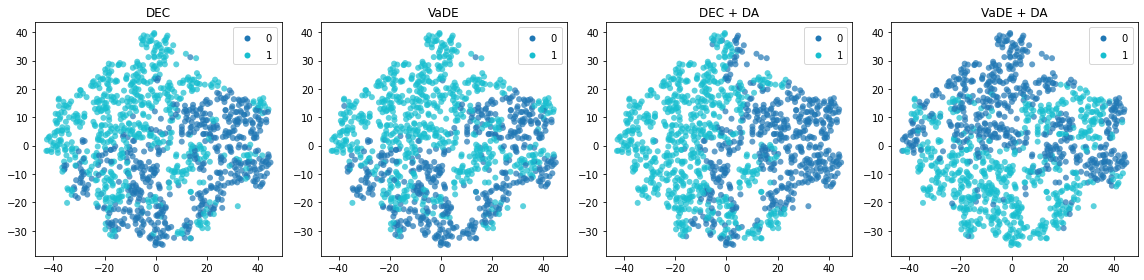

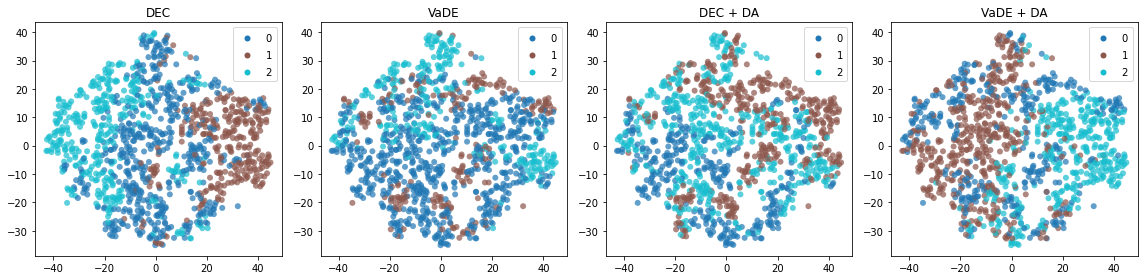

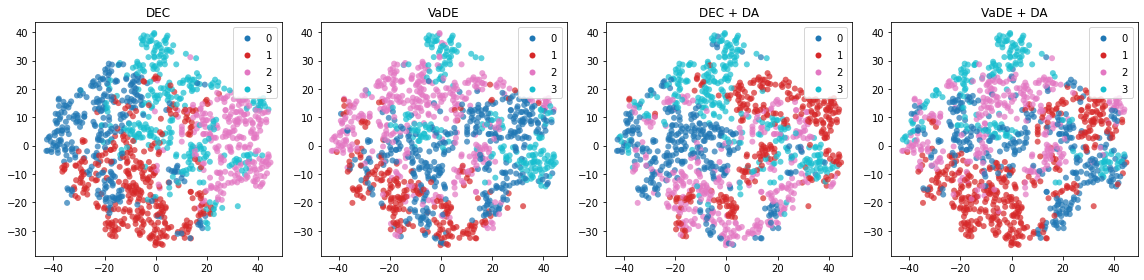

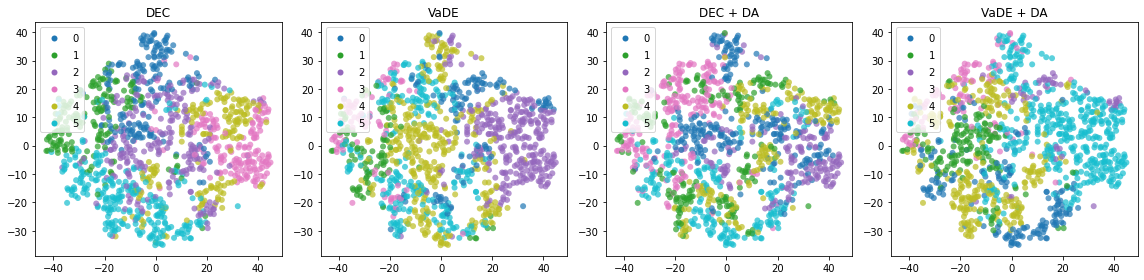

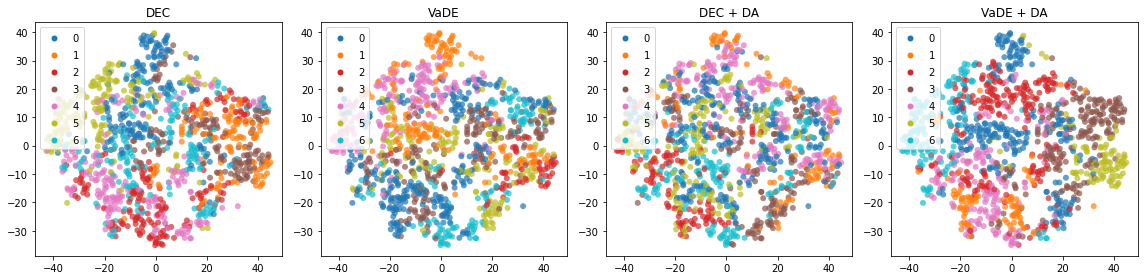

In [32]:
cluster_labels = pd.DataFrame(cluster_labels)
for k in categorical_variables.keys():
    clusters = cluster_labels[cluster_labels.n_clusters==k]
    labels = {clusters.rl_method[i]: clusters.labels[i] for i in clusters.index}
    draw_multiple_labels(z_vade_tsne, labels, max_cols=6)
    
    metrics = evaluate_clustering(z_vade_tsne, labels["DEC"], labels["DEC + DA"], False)
    print(f'DEC vs DEC + DA       - K={k}', [f'{metric}: {value:.3f}' for metric, value in metrics.items()])
    
    metrics = evaluate_clustering(z_vade_tsne, labels["VaDE"], labels["VaDE + DA"], False)
    print(f'VaDE vs VaDE + DA     - K={k}', [f'{metric}: {value:.3f}' for metric, value in metrics.items()])
    
    metrics = evaluate_clustering(z_vade_tsne, labels["DEC"], labels["VaDE"], False)
    print(f'DEC vs VaDE           - K={k}', [f'{metric}: {value:.3f}' for metric, value in metrics.items()])
    
    metrics = evaluate_clustering(z_vade_tsne, labels["DEC + DA"], labels["VaDE + DA"], False)
    print(f'DEC + DA vs VaDE + DA - K={k}', [f'{metric}: {value:.3f}' for metric, value in metrics.items()])

There seems to be some agreement between both methods, specially for K=2 and K=3.